## Notebook to examine error (standard deviation) of TCS using bootstrap method for whitepapers
This is estimated for TCS 2010 Decadal Survey Whitepapers

In [1]:
import pandas as pd
import os, sys
sys.path.append("../src")
from process import *

In [2]:
# Config section
version = '19_2_125_rec1'

# viz 19 (125 topics)
topics_to_estimate_errors = [29, 32, 45, 64, 70, 74, 91, 95, 97, 120]

In [3]:
# load data
topic_distrib_data = open_topic_distrib(version, 'whitepapers')

# process document inference data to get an idea of inferences by topic, for each paper in our data
data_by_paper = topic_distrib_data.drop(['Unnamed: 0'], axis=1)
data_by_paper[:1]

0         1         2         3         4         5         6  \
0  0.041421  0.000329  0.000339  0.000327  0.000304  0.000322  0.000319   

         7        8         9  ...       115       116       117       118  \
0  0.00032  0.00034  0.044078  ...  0.000325  0.000313  0.000319  0.000332   

        119      120       121       122       123       124  
0  0.000315  0.00032  0.000331  0.000327  0.000325  0.000322  

[1 rows x 125 columns]

In [4]:
k = list(data_by_paper.keys())
list(data_by_paper.keys())[:3]

['0', '1', '2']

In [5]:
len(data_by_paper.columns)

125

In [6]:
row_seq = list(range(0, len(data_by_paper)))
len(row_seq)

274

In [7]:
import numpy as np
import statistics

# sample data for bootstrap
import random
def sample_paragraphs(topic:str, data_by_paper:pd.DataFrame, samples_per_run:int=100):
    ''' find TCS or summed total inference from paragraphs for topic '''
    total_inference = 0
    
    keys = list(data_by_paper.keys())
    t_size = len(keys)
        
    # random sample, no replacement
    num_topics = len(data_by_paper.columns)
    
    # using random sampling of the rows, no replacement
    data = data_by_paper
    
    row_seq = list(range(0, len(data)))
    #print (row_seq)

    random_rows = random.sample(row_seq, samples_per_run)
    for random_row in random_rows:
        row_data = data[data.index==random_row]
        value = list(row_data[topic].values)[0]
        total_inference += value

    return total_inference

# sample data for bootstrap
def sample_paragraphs_repl(topic, data_by_paper:dict, samples_per_run:int=100):
    
    total_inference = 0
    
    t_size = len(data_by_paper.keys())
    
    # random sample with replacement.
    num_topics = len(data_by_paper.columns)
    
     # using random sampling of the rows, no replacement
    data = data_by_paper
    
    row_seq = list(range(0, len(data)))
    #print (row_seq)

    random_rows = []
    for i in range(0,samples_per_run):
        random_rows.append(random.choice(row_seq))
   
    for random_row in random_rows:
        row_data = data[data.index==random_row]
        value = list(row_data[topic].values)[0]
        total_inference += value

    return total_inference

def bootstrap_estimate (topic:str, data_by_paper:dict, \
                       num_times_to_sample:int=10, num_data_samples:int=10000,\
                       replacement:bool=True):
    
    """ Returns the mean and standard deviation for selected topic inference values """
    
    stats = []
    for i in range(0, num_times_to_sample):
        if replacement:
            stats.append(sample_paragraphs_repl(topic, data_by_paper, num_data_samples))
        else:
            stats.append(sample_paragraphs(topic, data_by_paper, num_data_samples))
    
    #calculate mean, standard deviation
    return statistics.mean(stats), np.std(stats)
    


In [8]:
# overall size (using smallest/first year)
len(data_by_paper[k[0]])

274

In [9]:
# choose to sample ~70% of the smallest year size
sample_size = int(len(data_by_paper) * 0.7)
sample_size

191

In [10]:
import time
start_time = time.time()

# bootstrap w/replacement is same as w/o replacement according to:
#  https://stats.stackexchange.com/questions/69744/why-at-all-consider-sampling-without-replacement-in-a-practical-application
# when applied to first-order statistics like mean and variance. w/o replacement should
# be used for higher order statistics (e.g. skewness, kurtosis)

# takes about 560 sec per ~18000 data samples per topic 
result = bootstrap_estimate("64", data_by_paper, 10, sample_size)
print (f" time to run: %5.2f sec" % (time.time()-start_time))
result

 time to run:  0.47 sec


(0.6102956209249002, 0.21320187236554608)

In [11]:
#start_time = time.time()
#result = bootstrap_estimate(64, data_by_paper, 10, 18000, replacement=False)
#print (f" time to run: %5.2f sec" % (time.time()-start_time))
#result

In [12]:
# Now defined above
results = {}
for topic in topics_to_estimate_errors:
    print (f"Doing topic {topic}")
    results[topic] = bootstrap_estimate(str(topic), data_by_paper, 10, sample_size, replacement=True)

Doing topic 29
Doing topic 32
Doing topic 45
Doing topic 64
Doing topic 70
Doing topic 74
Doing topic 91
Doing topic 95
Doing topic 97
Doing topic 120


In [13]:
results

{29: (0.46133424224029995, 0.13320717899668016),
 32: (1.3627058157251004, 0.2905644079065685),
 45: (0.8536000844518998, 0.1095721806858675),
 64: (0.5279143936755, 0.32653006183092176),
 70: (2.3912716355718997, 0.699412193136246),
 74: (2.1499680205441005, 0.5094859106387135),
 91: (0.5751401418779002, 0.23887497618672454),
 95: (1.3555758259588, 0.3184365653275134),
 97: (0.5082239376805, 0.18337072911617291),
 120: (1.8132168016363002, 0.3522798527781437)}

In [14]:
#timeseries_filename=f'../data/time_series_characteristics_{version}.csv'
# read in data with various info, each row is a topic number 
#timeseries_data = pd.read_csv(timeseries_filename, index_col=False)
#timeseries_data['count'][64]

In [15]:
topics = [t for t in results.keys()]
mean  = [results[t][0] for t in topics]
std    = [results[t][1] for t in topics]
#counts = [timeseries_data['count'][t] for t in topics]
r_data = pd.DataFrame({'topic':topics, 'mean':mean, 'std':std})

# save a copy
r_data.to_csv(f'../results/bootstrap_error_est_results_tcs_repl_DS2010_whitepapers_{version}.csv')
r_data

topic      mean       std
0     29  0.461334  0.133207
1     32  1.362706  0.290564
2     45  0.853600  0.109572
3     64  0.527914  0.326530
4     70  2.391272  0.699412
5     74  2.149968  0.509486
6     91  0.575140  0.238875
7     95  1.355576  0.318437
8     97  0.508224  0.183371
9    120  1.813217  0.352280

In [16]:
# overall population mean TCS and associated standard deviation
r_data['mean'].mean(), r_data['std'].mean()

(1.19989508993623, 0.31617340566035523)

<Axes: title={'center': 'Bootstrap Error Estimation (TCS, DS2010)'}, xlabel='TCS', ylabel='std'>

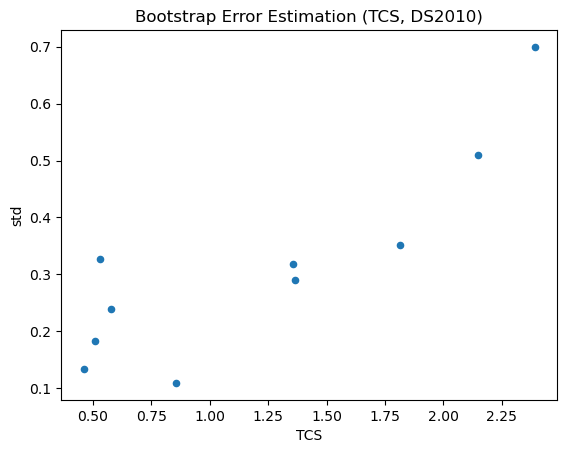

In [17]:
r_data.plot(kind='scatter', x='mean', y='std', xlabel="TCS", title="Bootstrap Error Estimation (TCS, DS2010)")